In [115]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 3                                               #
#                                                            #
##############################################################

# Updated by Dave Ebbelaar on 22-12-2022

from sklearn.decomposition import PCA
from scipy.signal import butter, lfilter, filtfilt
import copy
import pandas as pd

# This class removes the high frequency data (that might be considered noise) from the data.
# We can only apply this when we do not have missing values (i.e. NaN).
class LowPassFilter:
    def low_pass_filter(
        self,
        data_table,
        col,
        sampling_frequency,
        cutoff_frequency,
        order=5,
        phase_shift=True,
    ):
        # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
        # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
        nyq = 0.5 * sampling_frequency
        cut = cutoff_frequency / nyq

        b, a = butter(order, cut, btype="low", output="ba", analog=False)
        if phase_shift:
            data_table[col + "_lowpass"] = filtfilt(b, a, data_table[col])
        else:
            data_table[col + "_lowpass"] = lfilter(b, a, data_table[col])
        return data_table


# Class for Principal Component Analysis. We can only apply this when we do not have missing values (i.e. NaN).
# For this we have to impute these first, be aware of this.
class PrincipalComponentAnalysis:

    pca = []

    def __init__(self):
        self.pca = []

    def normalize_dataset(self, data_table, columns):
        dt_norm = copy.deepcopy(data_table)
        for col in columns:
            dt_norm[col] = (data_table[col] - data_table[col].mean()) / (
                data_table[col].max()
                - data_table[col].min()
                # data_table[col].std()
            )
        return dt_norm

    # Perform the PCA on the selected columns and return the explained variance.
    def determine_pc_explained_variance(self, data_table, cols):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components=len(cols))
        self.pca.fit(dt_norm[cols])
        # And return the explained variances.
        return self.pca.explained_variance_ratio_

    # Apply a PCA given the number of components we have selected.
    # We add new pca columns.
    def apply_pca(self, data_table, cols, number_comp):

        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components=number_comp)
        self.pca.fit(dt_norm[cols])

        # Transform our old values.
        new_values = self.pca.transform(dt_norm[cols])

        # And add the new ones:
        for comp in range(0, number_comp):
            data_table["pca_" + str(comp + 1)] = new_values[:, comp]

        return data_table

In [2]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 4                                               #
#                                                            #
##############################################################

# Updated by Dave Ebbelaar on 22-12-2022

import numpy as np
import scipy.stats as stats

# Class to abstract a history of numerical values we can use as an attribute.
class NumericalAbstraction:

    # This function aggregates a list of values using the specified aggregation
    # function (which can be 'mean', 'max', 'min', 'median', 'std')
    def aggregate_value(self, aggregation_function):
        # Compute the values and return the result.
        if aggregation_function == "mean":
            return np.mean
        elif aggregation_function == "max":
            return np.max
        elif aggregation_function == "min":
            return np.min
        elif aggregation_function == "median":
            return np.median
        elif aggregation_function == "std":
            return np.std
        else:
            return np.nan

    # Abstract numerical columns specified given a window size (i.e. the number of time points from
    # the past considered) and an aggregation function.
    def abstract_numerical(self, data_table, cols, window_size, aggregation_function):

        # Create new columns for the temporal data, pass over the dataset and compute values
        for col in cols:
            data_table[
                col + "_temp_" + aggregation_function + "_ws_" + str(window_size)
            ] = (
                data_table[col]
                .rolling(window_size)
                .apply(self.aggregate_value(aggregation_function))
            )

        return data_table

In [3]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 4                                               #
#                                                            #
##############################################################

# Updated by Dave Ebbelaar on 06-01-2023

import numpy as np


# This class performs a Fourier transformation on the data to find frequencies that occur
# often and filter noise.
class FourierTransformation:

    # Find the amplitudes of the different frequencies using a fast fourier transformation. Here,
    # the sampling rate expresses the number of samples per second (i.e. Frequency is Hertz of the dataset).
    def find_fft_transformation(self, data, sampling_rate):
        # Create the transformation, this includes the amplitudes of both the real
        # and imaginary part.
        transformation = np.fft.rfft(data, len(data))
        return transformation.real, transformation.imag

    # Get frequencies over a certain window.
    def abstract_frequency(self, data_table, cols, window_size, sampling_rate):

        # Create new columns for the frequency data.
        freqs = np.round((np.fft.rfftfreq(int(window_size)) * sampling_rate), 3)

        for col in cols:
            data_table[col + "_max_freq"] = np.nan
            data_table[col + "_freq_weighted"] = np.nan
            data_table[col + "_pse"] = np.nan
            for freq in freqs:
                data_table[
                    col + "_freq_" + str(freq) + "_Hz_ws_" + str(window_size)
                ] = np.nan

        # Pass over the dataset (we cannot compute it when we do not have enough history)
        # and compute the values.
        for i in range(window_size, len(data_table.index)):
            for col in cols:
                real_ampl, imag_ampl = self.find_fft_transformation(
                    data_table[col].iloc[
                        i - window_size : min(i + 1, len(data_table.index))
                    ],
                    sampling_rate,
                )
                # We only look at the real part in this implementation.
                for j in range(0, len(freqs)):
                    data_table.loc[
                        i, col + "_freq_" + str(freqs[j]) + "_Hz_ws_" + str(window_size)
                    ] = real_ampl[j]
                # And select the dominant frequency. We only consider the positive frequencies for now.

                data_table.loc[i, col + "_max_freq"] = freqs[
                    np.argmax(real_ampl[0 : len(real_ampl)])
                ]
                data_table.loc[i, col + "_freq_weighted"] = float(
                    np.sum(freqs * real_ampl)
                ) / np.sum(real_ampl)
                PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
                PSD_pdf = np.divide(PSD, np.sum(PSD))
                data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)

        return data_table

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("/content/02_data_outlier_removed.pkl")
predictor_columns = df.columns[:6]
# Plot settings
plt.style.use("fivethirtyeight")
100
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"]

100.0

In [5]:
# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------
for col in predictor_columns:
  df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyro_x       9009 non-null   float64
 4   gyro_y       9009 non-null   float64
 5   gyro_z       9009 non-null   float64
 6   participant  9009 non-null   object 
 7   excercise    9009 non-null   object 
 8   intensity    9009 non-null   object 
 9   ind          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


In [47]:
# --------------------------------------------------------------
# Calculating ind duration
# --------------------------------------------------------------
for set_ind in np.sort(df["ind"].unique()):
  duration = df[df["ind"] == set_ind].index[-1] - df[df["ind"] == set_ind].index[0]
  print(f"Set {set_ind} duration is {duration.seconds}")
  df.loc[(df["ind"] == set_ind), "duration"] = duration.seconds


Set 1 duration is 12
Set 2 duration is 39
Set 3 duration is 26
Set 4 duration is 14
Set 5 duration is 15
Set 6 duration is 14
Set 7 duration is 25
Set 8 duration is 14
Set 9 duration is 20
Set 10 duration is 35
Set 11 duration is 15
Set 12 duration is 19
Set 13 duration is 26
Set 14 duration is 21
Set 15 duration is 9
Set 16 duration is 9
Set 17 duration is 19
Set 18 duration is 26
Set 19 duration is 16
Set 20 duration is 16
Set 21 duration is 19
Set 22 duration is 14
Set 23 duration is 15
Set 24 duration is 32
Set 25 duration is 29
Set 26 duration is 13
Set 27 duration is 30
Set 28 duration is 16
Set 29 duration is 12
Set 30 duration is 24
Set 31 duration is 34
Set 32 duration is 15
Set 33 duration is 18
Set 34 duration is 20
Set 35 duration is 33
Set 37 duration is 17
Set 38 duration is 8
Set 39 duration is 34
Set 40 duration is 14
Set 41 duration is 18
Set 42 duration is 39
Set 43 duration is 8
Set 44 duration is 26
Set 45 duration is 26
Set 46 duration is 15
Set 47 duration is 20
S

In [51]:
df["intensity"] = df["intensity"].replace(regex={r'^heavy.*': 'heavy', r'^medium.*': 'medium'})

In [54]:
dataset = df.groupby("intensity").duration.mean()
print(dataset[0] / 5)
print(dataset[1] / 10)

2.9487001733102254
2.4942528735632186


In [96]:
# --------------------------------------------------------------
# Butterworth lowpass filter
# --------------------------------------------------------------
df_lowpass = df.copy()
low_pass = LowPassFilter()

df_lowpass = low_pass.low_pass_filter(df_lowpass,
        "acc_y",
        sampling_frequency = 1/0.2,
        cutoff_frequency = 1.3,
        order=5,
        phase_shift=True)

In [97]:
df_lowpass[df_lowpass["excercise"] == "dead"]

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,participant,excercise,intensity,ind,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 16:24:24.800,0.056500,-1.027000,-0.165500,3.231667,-2.6830,2.418667,A,dead,medium,54,30.0,-0.557444
2019-01-11 16:24:25.000,0.073333,-1.025000,-0.155333,12.853600,-30.9024,4.487800,A,dead,medium,54,30.0,-1.115317
2019-01-11 16:24:25.200,0.059000,-1.022000,-0.125500,2.073200,-1.2316,3.170800,A,dead,medium,54,30.0,-1.151632
2019-01-11 16:24:25.400,0.030667,-1.031667,-0.114667,-0.329600,3.1098,1.817000,A,dead,medium,54,30.0,-0.997946
2019-01-11 16:24:25.600,0.046500,-1.025500,-0.124500,-0.975600,9.7682,-2.219400,A,dead,medium,54,30.0,-0.967862
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-16 19:35:42.800,0.015000,-1.083000,-0.164500,-0.341600,-6.3658,2.390200,E,dead,heavy,84,16.0,-1.082662
2019-01-16 19:35:43.000,-0.007000,-1.308000,-0.209333,4.939000,31.2440,-21.219400,E,dead,heavy,84,16.0,-1.147122
2019-01-16 19:35:43.200,0.161500,-1.003000,-0.113500,-4.427000,7.7680,12.585400,E,dead,heavy,84,16.0,-1.222793


dead


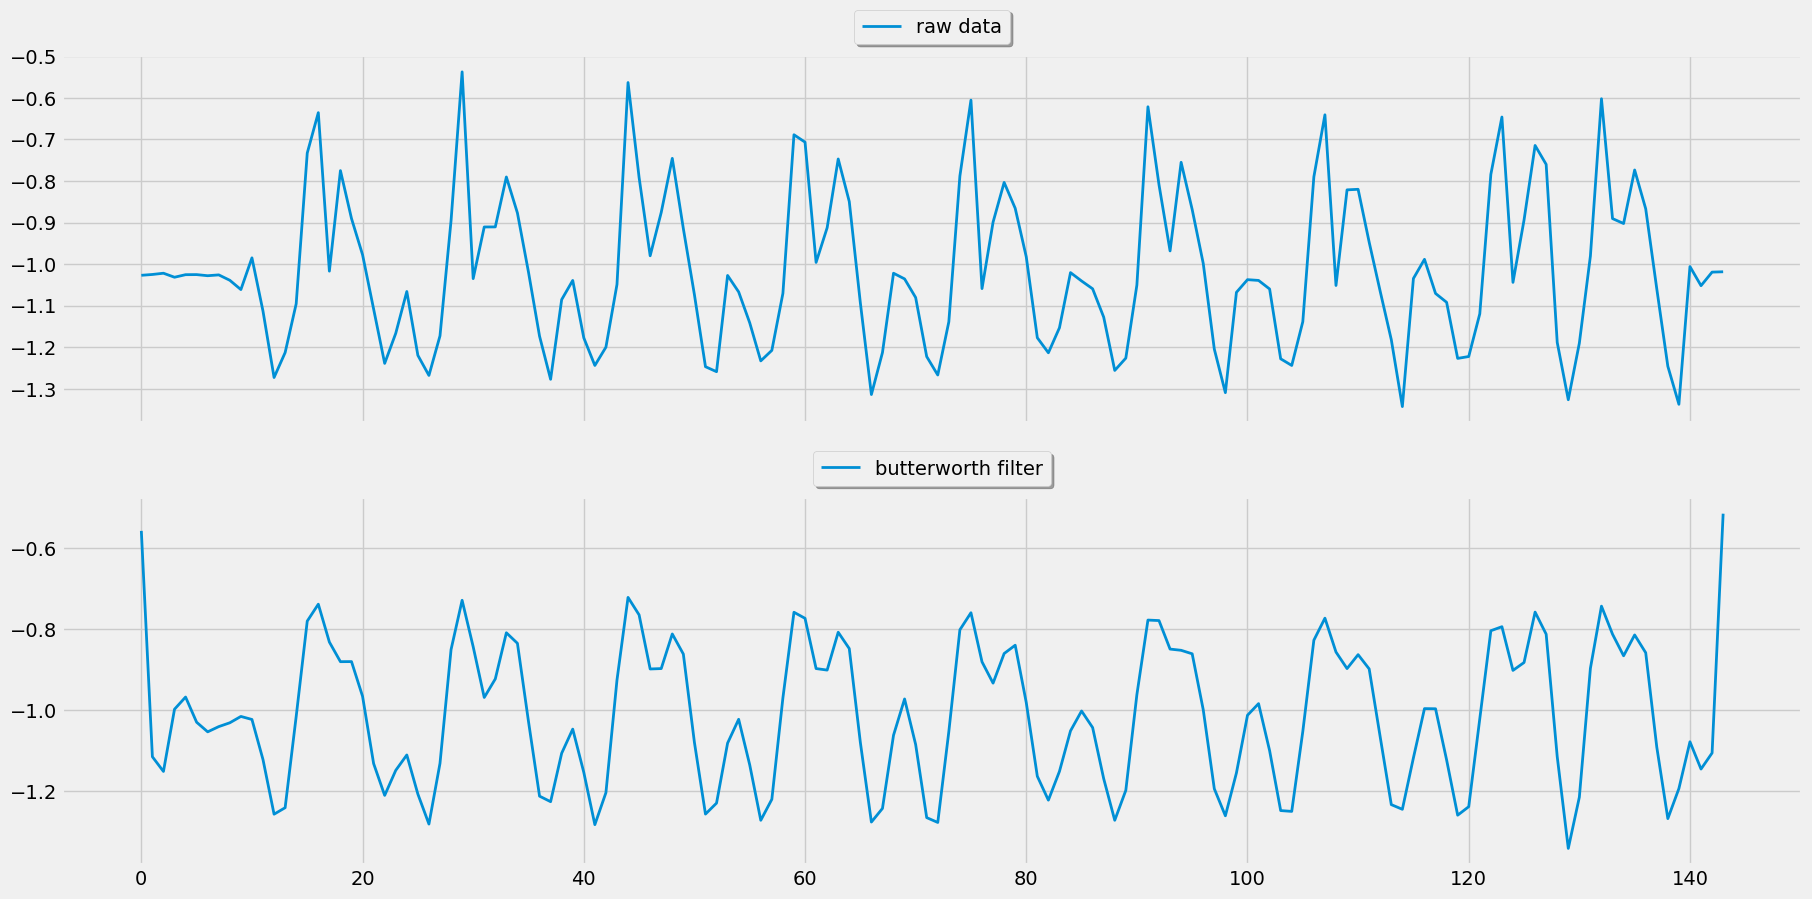

In [98]:
subset = df_lowpass[df_lowpass["ind"] == 54]
print(subset ["excercise"][0])
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset ["acc_y"].reset_index (drop=True), label="raw data")
ax[1].plot(subset ["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend (loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax [1]. legend (loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)


In [101]:
# Loop to add on all columns
df_lowpass = df.copy()
for col in predictor_columns:
  low_pass = LowPassFilter()
  df_lowpass = low_pass.low_pass_filter(df_lowpass,
        col,
        sampling_frequency = 1/0.2,
        cutoff_frequency = 1.3,
        order=5,
        phase_shift=True)
df_lowpass.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,participant,excercise,intensity,ind,duration,acc_x_lowpass,acc_y_lowpass,acc_z_lowpass,gyro_x_lowpass,gyro_y_lowpass,gyro_z_lowpass
epoch (ms),,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,28,16.0,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,28,16.0,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,28,16.0,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,28,16.0,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,28,16.0,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172


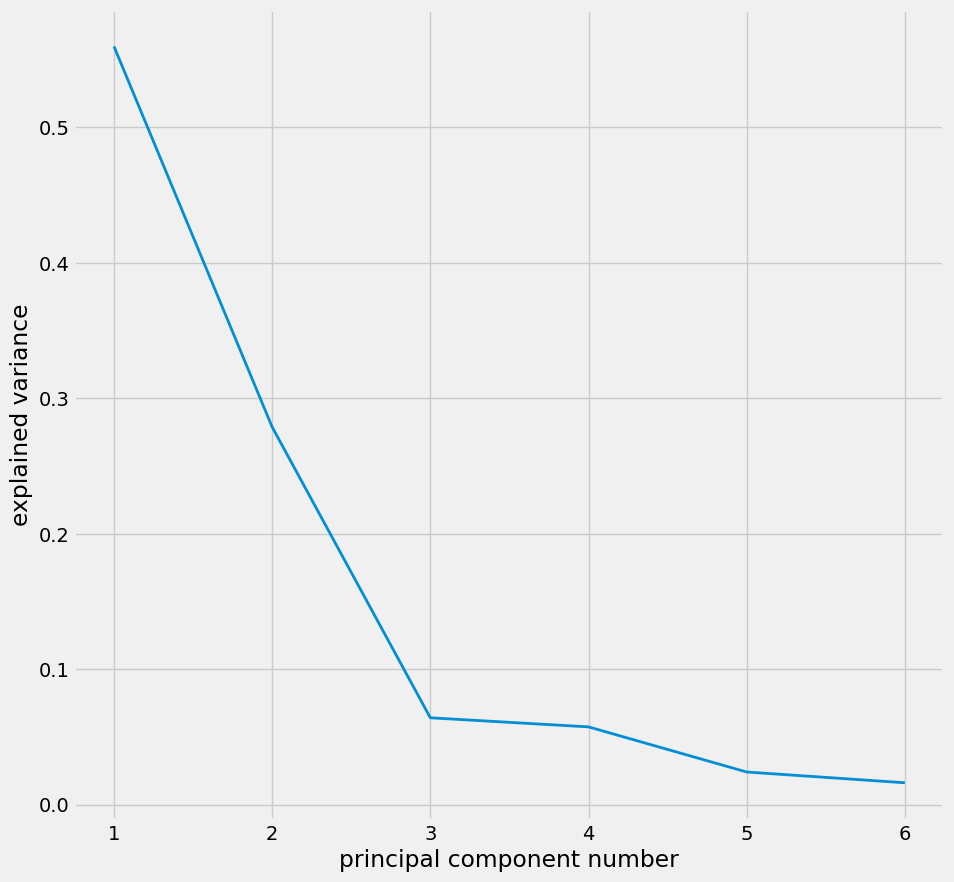

In [120]:
# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------
pca_new = PrincipalComponentAnalysis()
df_pca = df_lowpass.copy()

pc_values = pca_new.determine_pc_explained_variance(df_pca, predictor_columns)

plt.figure(figsize=(10, 10))
plt.plot(range(1, len (predictor_columns) + 1), pc_values)
plt.xlabel("principal component number")
plt.ylabel("explained variance")
plt.show()

In [121]:
df_pca = pca_new.apply_pca(df_pca, predictor_columns, 3)

In [122]:
df_pca.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,participant,excercise,intensity,ind,duration,acc_x_lowpass,acc_y_lowpass,acc_z_lowpass,gyro_x_lowpass,gyro_y_lowpass,gyro_z_lowpass,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,28,16.0,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,-0.291270,-0.077753,-0.004902
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,28,16.0,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,-0.290466,-0.084844,-0.003489
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,28,16.0,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,-0.290224,-0.075844,-0.024068
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,28,16.0,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,-0.287505,-0.084981,-0.045482
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,28,16.0,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,-0.289006,-0.108973,-0.024657


<Axes: >

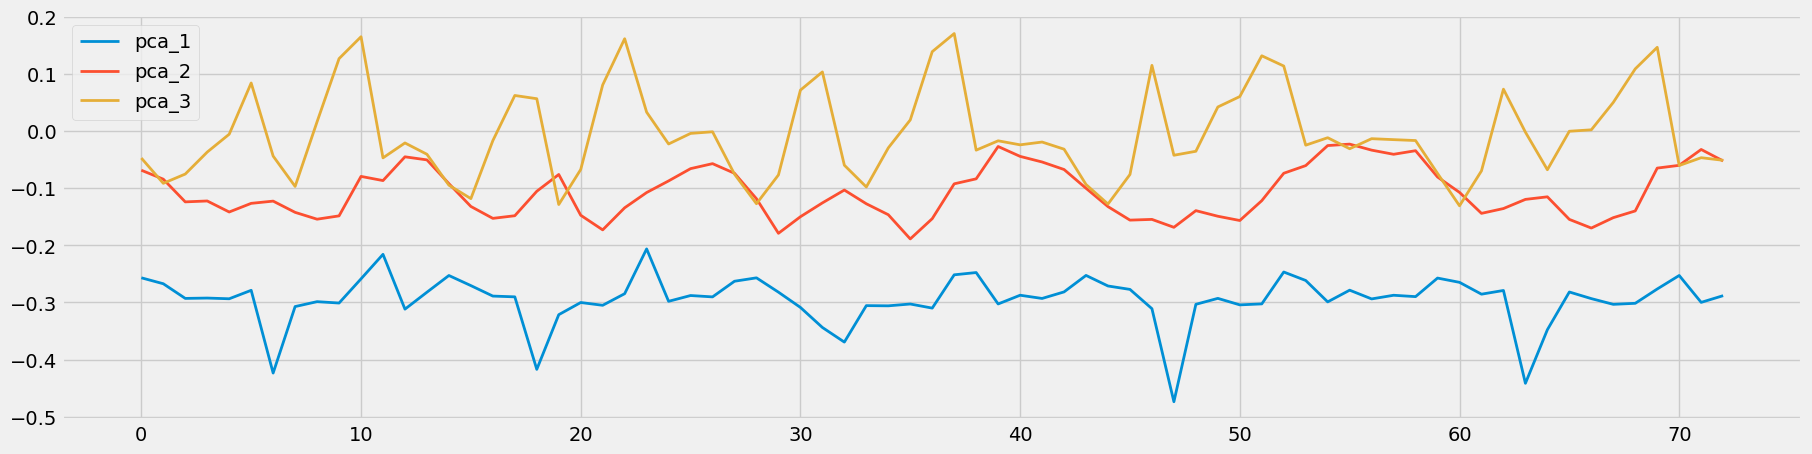

In [135]:
df_pca[df_pca["ind"] == 40].iloc[:, -3:].reset_index(drop= True).plot()

In [148]:
# --------------------------------------------------------------
# Sum of squares attributes
# --------------------------------------------------------------
df_pca["acc_sum"] = np.sqrt(np.sum(df_pca[["acc_x", "acc_y", "acc_z"]] ** 2, axis = 1))
df_pca["gyro_sum"] = np.sqrt(np.sum(df_pca[["gyro_x", "gyro_y", "gyro_z"]] ** 2, axis = 1))

array([<Axes: >, <Axes: >], dtype=object)

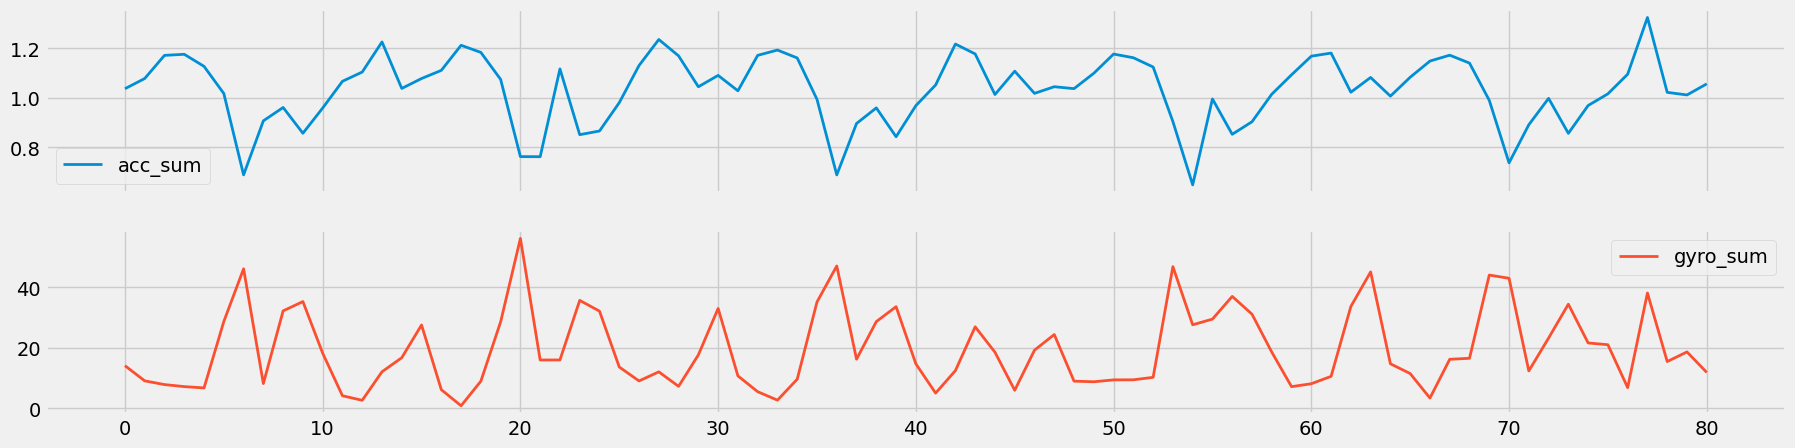

In [155]:

df_pca[df_pca["ind"] == 84].iloc[:, -2:].reset_index(drop= True).plot(subplots = True)

In [156]:
df_pca.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,participant,excercise,intensity,ind,...,acc_y_lowpass,acc_z_lowpass,gyro_x_lowpass,gyro_y_lowpass,gyro_z_lowpass,pca_1,pca_2,pca_3,acc_sum,gyro_sum
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,28,...,0.977003,-0.071001,-1.886218,2.438803,0.937522,-0.291270,-0.077753,-0.004902,0.979669,3.225625
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,28,...,0.973169,-0.066481,-0.367396,0.439794,0.178360,-0.290466,-0.084844,-0.003489,0.973752,2.887270
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,28,...,0.966879,-0.071895,4.320608,-2.083978,-1.217263,-0.290224,-0.075844,-0.024068,0.973795,2.936720
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,28,...,0.962244,-0.084774,4.737252,-3.456339,-0.678205,-0.287505,-0.084981,-0.045482,0.960118,9.473502
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,28,...,0.959572,-0.096776,0.808615,-1.194575,-1.783172,-0.289006,-0.108973,-0.024657,0.964953,4.623585


In [ ]:
# --------------------------------------------------------------
# Temporal abstraction
# --------------------------------------------------------------




In [ ]:
# --------------------------------------------------------------
# Frequency features
# --------------------------------------------------------------



In [ ]:

# --------------------------------------------------------------
# Dealing with overlapping windows
# --------------------------------------------------------------




In [ ]:
# --------------------------------------------------------------
# Clustering
# --------------------------------------------------------------



In [ ]:

# --------------------------------------------------------------
# Export dataset
# --------------------------------------------------------------